Real State Price Prediction System

# 1. Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle
import json

# 2. Reading Data
We will use pandas `read_csv` function to read the data in csv file.

In [2]:
filepath = r'C:\Users\#stormy\Desktop\python\notebook\project\Bengaluru_House_Data.csv'    #filepath of the dataset
data = pd.read_csv(filepath)
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price in lakhs
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# 3. Data Preprcessing
Data preprocessing is a data mining technique that involves transforming raw data into an understandable format.

In [3]:
data.shape

(13320, 9)

In [4]:
data.groupby('area_type')['area_type'].agg('count')    # taking the 'area_type' column as a group and counting its values

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

`groupby()` function is used to split the data into groups based on some criteria
and
`agg()` function abbreviation of aggregate is used to define what we want to do with the grouped data.


In [5]:
data2 = data.drop(['area_type','society','balcony','availability'], axis='columns')     # dropping useless columns
data2.head()

,location,size,total_sqft,bath,price in lakhs
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [6]:
data2.isnull().sum()     # finding total empty values in each column

location           1
size              16
total_sqft         0
bath              73
price in lakhs     0
dtype: int64

In [7]:
data3 = data2.dropna()    # dropping 'NA' values
data3.isnull().sum()

location          0
size              0
total_sqft        0
bath              0
price in lakhs    0
dtype: int64

In [8]:
data3.shape

(13246, 5)

In [9]:
data3['size'].unique()    # checking unique values in size column

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
data3['bhk'] = data3['size'].apply(lambda x: int(x.split(' ')[0]))    # getting the number of bedrooms from size column

<ipython-input-10-3d8702cc8485>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['bhk'] = data3['size'].apply(lambda x: int(x.split(' ')[0]))    # getting the number of bedrooms from size column


In [11]:
data3.head()

,location,size,total_sqft,bath,price in lakhs,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
data3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [13]:
data3[data3.bhk>20]    

,location,size,total_sqft,bath,price in lakhs,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


Finding rows with extraordinary values! (Outliers)

In [14]:
data3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [15]:
def is_float(x):
    '''
    Function to convert values into float dtype.
    '''
    try:
        float(x)
    except:
        return False
    return True

In [16]:
data3[~data3['total_sqft'].apply(is_float)].head(20)    # finding values those not got converted

,location,size,total_sqft,bath,price in lakhs,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [17]:
def convert_sqft_to_sum(x):
    '''
    Function to convert those unusual format of data
    '''
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

In [18]:
convert_sqft_to_sum('2100 - 2850')    # usage of the function

2475.0

In [19]:
data4 = data3.copy()
data4['total_sqft'] = data4['total_sqft'].apply(convert_sqft_to_sum)
data4.head()

,location,size,total_sqft,bath,price in lakhs,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [20]:
data4.loc[30]    # loc function is used to see data row-wise

location          Yelahanka
size                  4 BHK
total_sqft             2475
bath                      4
price in lakhs          186
bhk                       4
Name: 30, dtype: object

In [21]:
data5 = data4.copy()    # copy function is used to copy the whole dataframe
data5.head()

,location,size,total_sqft,bath,price in lakhs,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [22]:
data5['price_per_sqft'] = data5['price in lakhs'] * 100000/data5['total_sqft']    # making a new column in the dataframe named `price_per_sqft` and see the logic to create it


In [23]:
len(data5.location.unique())

1304

In [24]:
data5.location = data5.location.apply(lambda x : x.strip())    # strip is used to remove the white spaces around the data points

location_stats = data5.groupby('location')['location'].agg('count').sort_values(ascending=False)    # sorting the location column in descending order
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [25]:
len(location_stats[location_stats<=10])    # totaling the minor locations

1052

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [27]:
data5.location = data5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)    # changing minor locations into `other`

In [28]:
len(data5.location.unique())

242

In [29]:
data5[data5.total_sqft / data5.bhk < 300].head()    # checking for outliners; like a house with 1407 sq. area can't have 6 bedrooms

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
data5.shape

(13246, 7)

In [31]:
data6 = data5[~(data5.total_sqft/data5.bhk<300)]
data6

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [32]:
data6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [33]:
data6.shape

(12502, 7)

# 4. Data Cleaning
In this section, we will find outliers and try to remove them.

In [34]:
def remove_pps_outliers(df):
    
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
        

In [35]:
data7 = remove_pps_outliers(data6)
data7.shape

(10241, 7)

In [36]:
data7.head()

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [37]:
def remove_bhk_outliers(df):
    '''
    Function to clear stuff (outliers) in the bhk column so that we don't live in a hypothetical dataset. 😄
    '''
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

data8 = remove_bhk_outliers(data7)
data8.shape

(7329, 7)

# 5. Data Visualization
Time to visualize our data

In [38]:
def plot_scatter_chart(df,location):
   
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price_per_sqft,color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price_per_sqft,marker='+',color='green', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price Per Square Feet')
    plt.title(location)
    plt.legend()

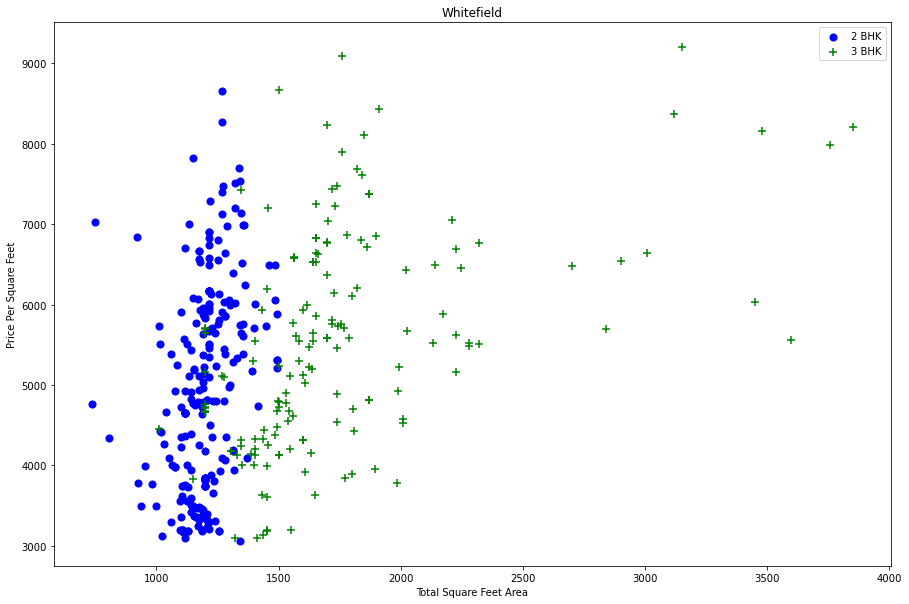

In [39]:
plot_scatter_chart(data7, 'Whitefield')

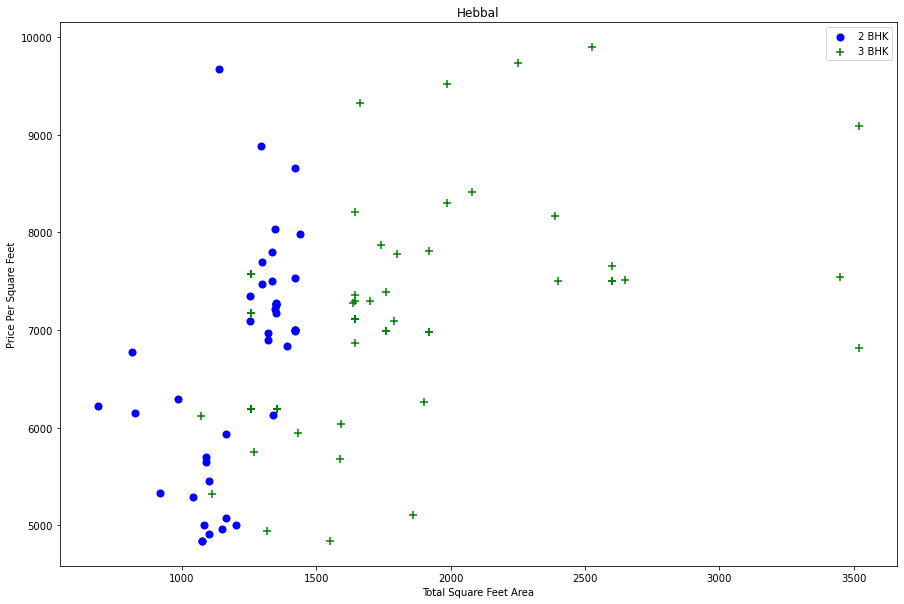

In [40]:
plot_scatter_chart(data7,"Hebbal")

Text(0, 0.5, 'Count')

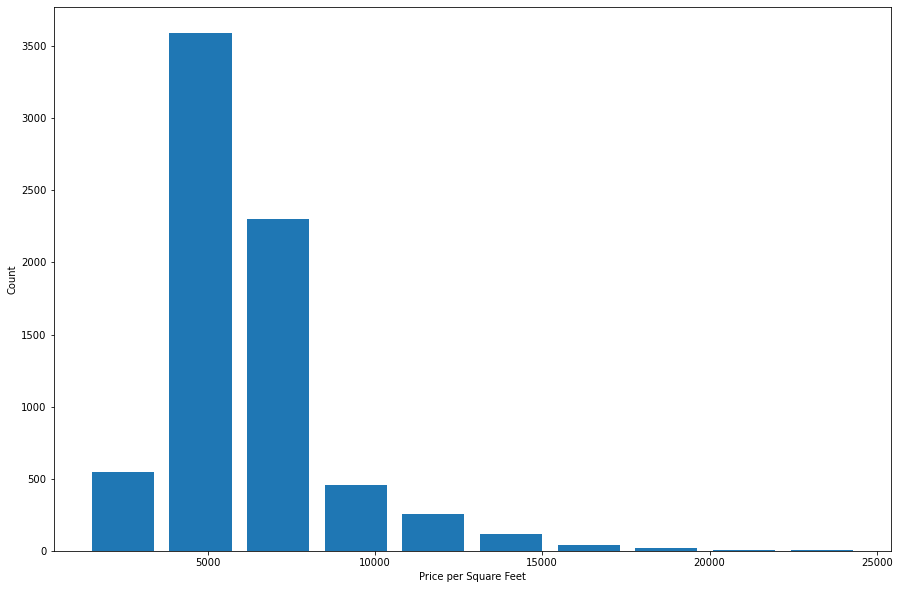

In [41]:
plt.hist(data8.price_per_sqft, rwidth=0.8)    # visualization the price_per_sqft column
plt.xlabel('Price per Square Feet')
plt.ylabel('Count')

In [42]:
data8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [43]:
data8[data8.bath>10]    # Again some idiot outliers😆

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

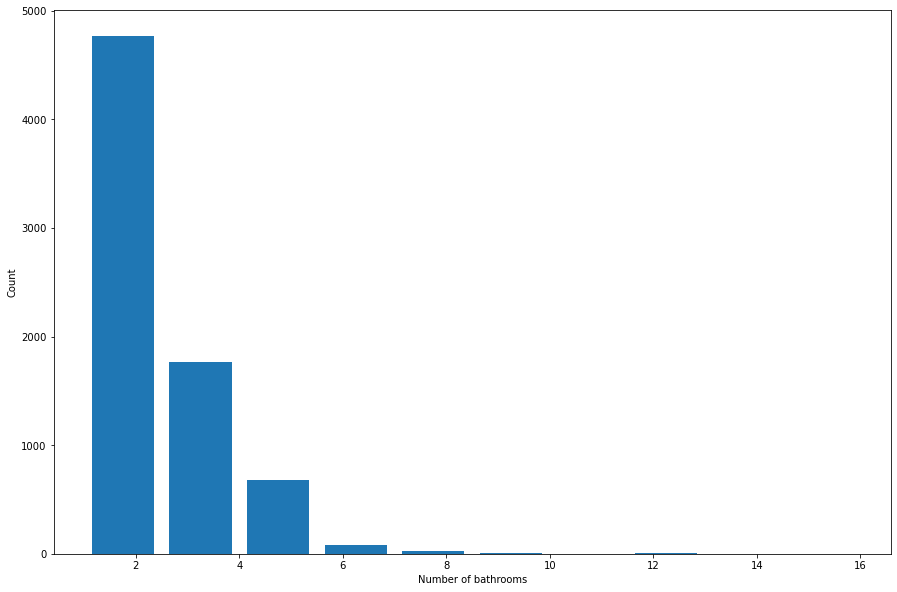

In [44]:
plt.hist(data8.bath, rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

In [45]:
data8[data8.bath > data8.bhk + 2]   

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [46]:
data9 = data8[data8.bath < data8.bhk + 2]
data9.shape

(7251, 7)

In [47]:
data9.sample()    # sample return a random row from the dataset

,location,size,total_sqft,bath,price in lakhs,bhk,price_per_sqft
9793,other,2 Bedroom,1348.0,2.0,100.0,2,7418.397626


In [48]:
data10 = data9.drop(['size',"price_per_sqft"],axis='columns')    # removing or dropping 'size' and 'prize_per_sqft' as we don't require them any more
data10.head()

,location,total_sqft,bath,price in lakhs,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# 6. Creating Dummies
We will use pandas' `get_dummies()` to create dummies variables.
It is used for data manipulation. It converts categorical data into dummy or indicator variables.

In [49]:
dummies = pd.get_dummies(data10.location)     
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
data11 = pd.concat([data10, dummies.drop('other', axis='columns')], axis='columns')    # joining the dummy values again with the dataset except 'other' column
data11.head()

,location,total_sqft,bath,price in lakhs,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
data12 = data11.drop('location', axis='columns')    # dropping original location as now we have dummmies in its place.
data12.head()

,total_sqft,bath,price in lakhs,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 7. Splitting Data for Training and Testing
Before Training the model, it is required to split the data into train and test data. For this we will use, sklearn's `train_test_split`


In [52]:
X = data12.drop('price in lakhs', axis='columns')    # dropping price column as we don't want it in our train dataset
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
X.shape

(7251, 244)

In [54]:
y = data12['price in lakhs']   # taking the price column as our target to predict

In [55]:
y.shape

(7251,)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)    # splitting the the data into train and test data as 80 : 20 ratio

In [57]:
X_train.shape

(5800, 244)

# 8. Training the Models
Preciesly, we will be trying more than one model, therefore, Training the `Models`

In [58]:
lr_clf = LinearRegression()     # first trying training with LinearRegression 
lr_clf.fit(X_train, y_train) #Training the dataset
lr_clf.score(X_test, y_test) 

0.8452277697874312

In [59]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)     # ShuffleSplit is just a another type of splitting data
cross_val_score(LinearRegression(), X, y, cv=cv)     

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

Cross Validation is mainly used for the comparison of different models. For each model, you may get the average generalization error on the k validation sets. Then you will be able to choose the model with the lowest average generation error as your optimal model.

In [60]:
def find_best_model_using_gridsearchcv(X,y):
    '''
    Function to try different models at once of the data with different parameters to find the best ones.
    '''
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params':{
                'normalize':[True,False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha' : [1,2],
                'selection':['random','cyclic']
            }
        },
        'decision_tree':{
            'model': DecisionTreeRegressor(),
            'params':{
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'], cv=cv, return_train_score=False)     # GridSearchCV is the main focus as it helps to try out the different parameters for the different models.
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score':gs.best_score_,
            'best_params':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])     # At last binding the results of the models with best params. into a DataFrame.

In [61]:
find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': True}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.716410,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


As we can see the LinearRegression model performed the best, so we are going to use as it for prediction.

# 9. Prediction Time
Predicting the prices using LinearRegression in Lakhs.

In [62]:
def predict_price(location,sqft,bath,bhk):
    '''
    Function which helps to actually predict the prices.
    '''
    loc_index = np.where(X.columns==location)[0][0]     # np.where() function returns the indices of elements in an input array where the given condition is satisfied.
    
    x = np.zeros(len(X.columns))    # np.zeros() function returns a new array of given shape and type, with zeros.
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr_clf.predict([x])[0]

In [63]:
print(predict_price('1st Phase JP Nagar', 1000, 2, 3).round(3),'Lakhs')


81.726 Lakhs


In [64]:
print(predict_price('1st Block Jayanagar',2900,4,4))

359.49348388487215


# 10. Saving Model
For saving the model, we will be using `pickle` module and `json` module for saving the locations' names.

In [65]:
with open('BHP_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [66]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))